In [2]:
import pandas as pd
import folium
import random
from shapely.geometry import LineString
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
from concurrent.futures import ThreadPoolExecutor

route_data_df = pd.read_parquet(r"DataBase/route_data.parquet")
actual_sequences_df = pd.read_parquet(r"DataBase/actual_sequences.parquet")
print(route_data_df.columns)
print(actual_sequences_df.columns)
print(route_data_df.info)
print(route_data_df.info)

Index(['RouteID', 'StationCode', 'Date', 'DepartureTimeUTC',
       'ExecutorCapacityCm3', 'RouteScore', 'StopID', 'Latitude', 'Longitude',
       'Type', 'ZoneID'],
      dtype='object')
Index(['RouteID', 'StopID', 'Sequence'], dtype='object')
<bound method DataFrame.info of                                              RouteID StationCode        Date  \
0       RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77        DLA3  2018-07-27   
1       RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77        DLA3  2018-07-27   
2       RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77        DLA3  2018-07-27   
3       RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77        DLA3  2018-07-27   
4       RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77        DLA3  2018-07-27   
...                                              ...         ...         ...   
904522  RouteID_fffd257c-3041-4736-be7a-5efea8af1173        DCH4  2018-08-03   
904523  RouteID_fffd257c-3041-4736-be7a-5efea8af1173        DCH4  2018-08-03   
904

In [3]:
route_data_df = route_data_df.drop(columns=['StationCode', 'Date', 'DepartureTimeUTC','ExecutorCapacityCm3','Type'])


# Assurez-vous que les deux DataFrames sont triés par RouteID et StopID
route_data_df = route_data_df.sort_values(by=['RouteID', 'StopID']).reset_index(drop=True)
actual_sequences_df = actual_sequences_df.sort_values(by=['RouteID', 'StopID']).reset_index(drop=True)
actual_sequences_df = actual_sequences_df.rename(columns={'StopID': 'StopID2'})

In [4]:
# Concaténer les DataFrames le long des colonnes
data = pd.concat([route_data_df, actual_sequences_df.drop(columns='RouteID')], axis=1)
data = data.drop(columns=['StopID2'])
# Afficher les premières lignes du DataFrame concaténé
print(data.head())
print(data.info)


                                        RouteID RouteScore StopID   Latitude  \
0  RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77       High     AD  34.099611   
1  RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77       High     AF  34.101587   
2  RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77       High     AG  34.089727   
3  RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77       High     BA  34.096132   
4  RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77       High     BE  34.098482   

    Longitude   ZoneID  Sequence  
0 -118.283062  P-12.3C       105  
1 -118.291125   A-1.2D        47  
2 -118.285530   A-2.1A         4  
3 -118.292869   A-1.2C        33  
4 -118.286243  P-13.3B       109  
<bound method DataFrame.info of                                              RouteID RouteScore StopID  \
0       RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77       High     AD   
1       RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77       High     AF   
2       RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77   

In [5]:
def map_longitude_to_city(longitude):
    if -125 <= longitude <= -120:
        return "Seattle"
    elif -119 <= longitude <= -115:
        return "LA"
    elif -110 <= longitude <= -105:
        return "Denver"
    elif -105 <= longitude <= -95:
        return "Austin"
    elif -89 <= longitude <= -85:
        return "Chicago"
    elif -75 <= longitude <= -68:
        return "Boston"
    else:
        return None

data["City"] = data["Longitude"].apply(map_longitude_to_city)
data.head(5)

,RouteID,RouteScore,StopID,Latitude,Longitude,ZoneID,Sequence,City
0,RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77,High,AD,34.099611,-118.283062,P-12.3C,105,LA
1,RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77,High,AF,34.101587,-118.291125,A-1.2D,47,LA
2,RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77,High,AG,34.089727,-118.285530,A-2.1A,4,LA
3,RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77,High,BA,34.096132,-118.292869,A-1.2C,33,LA
4,RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77,High,BE,34.098482,-118.286243,P-13.3B,109,LA


In [6]:
# Assurez-vous que les données sont triées par ordre de StopID
data = data.sort_values(by=['RouteID', 'Sequence'])

      City  UniqueRouteCount
0   Austin               214
1   Boston               929
2  Chicago              1002
3       LA              2888
4  Seattle              1079


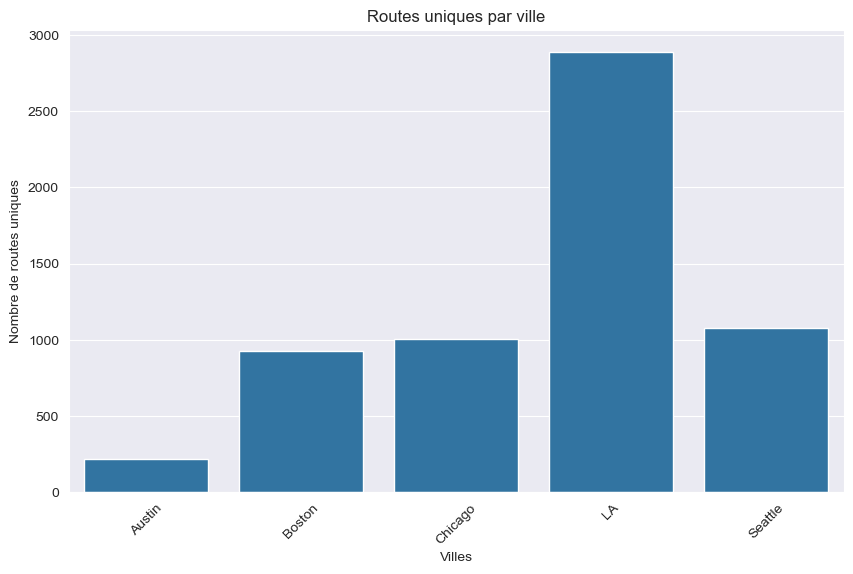

In [7]:
# Export the DataFrame to a CSV file
'''
data.to_csv("combined_routes_city.csv", index=False)

print(data["RouteID"].nunique())
'''
# Calculer le nombre unique de routes par ville
unique_routes_by_city = data.groupby("City")["RouteID"].nunique().reset_index()

# Renommer les colonnes pour une meilleure compréhension
unique_routes_by_city.columns = ["City", "UniqueRouteCount"]

# Afficher le DataFrame
print(unique_routes_by_city)

# Créer un graphique à barres avec Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="City", y="UniqueRouteCount", data=unique_routes_by_city)
plt.xlabel("Villes")
plt.ylabel("Nombre de routes uniques")
plt.title("Routes uniques par ville")
plt.xticks(rotation=45)
plt.show()

Ajout avec ZoneID

In [8]:

# Filtrer le DataFrame pour inclure uniquement les lignes avec "Boston" dans la colonne "City"
data_boston = data[data["City"] == "Boston"]

# Obtenir 20 IDs de routes aléatoires uniques
num_routes_to_plot = 10
random_routes = random.sample(list(set(data_boston["RouteID"])), num_routes_to_plot)

# Filtrer le DataFrame pour inclure uniquement les lignes avec les IDs de routes sélectionnés
random_routes_data = data_boston[data_boston["RouteID"].isin(random_routes)]

# Créer une carte Folium centrée autour de Boston
Boston_map = folium.Map(location=[42.3601, -71.0589], zoom_start=11)

# Grouper les données filtrées par ZoneID et calculer les valeurs maximales et minimales de latitude et de longitude pour chaque groupe
grouped_data = random_routes_data.groupby("ZoneID").agg({
    "Latitude": ["min", "max"],
    "Longitude": ["min", "max"]
}).reset_index()

# Itérer à travers chaque groupe et ajouter un carré à la carte
for _, row in grouped_data.iterrows():
    zone_id = row["ZoneID"].values[0] if isinstance(row["ZoneID"], pd.Series) else row["ZoneID"]
    lat_min = row[("Latitude", "min")]
    lat_max = row[("Latitude", "max")]
    lon_min = row[("Longitude", "min")]
    lon_max = row[("Longitude", "max")]

    # Définir les coordonnées du carré
    coordinates = [
        [lat_min, lon_min],
        [lat_min, lon_max],
        [lat_max, lon_max],
        [lat_max, lon_min],
        [lat_min, lon_min]
    ]

    # Ajouter le carré à la carte avec un popup affichant le ZoneID
    folium.PolyLine(locations=coordinates, color='green', weight=4, opacity=0.8).add_to(Boston_map)

    # Ajouter le nom de la zone (ZoneID) directement sur la carte
    center_lat = (lat_min + lat_max) / 2
    center_lon = (lon_min + lon_max) / 2
    folium.Marker(
        location=[center_lat, center_lon],
        icon=folium.DivIcon(html=f'<div style="color : red; font-weight: bold; font-size: 14px;">{zone_id}</div>')
    ).add_to(Boston_map)

# Tracer les itinéraires sélectionnés sur la carte avec des lignes reliant les arrêts
for route_id in random_routes:
    route_data = random_routes_data[random_routes_data["RouteID"] == route_id]
    coordinates = list(zip(route_data["Latitude"], route_data["Longitude"]))
    folium.PolyLine(locations=coordinates, color='blue').add_to(Boston_map)

# Sauvegarder la carte en tant que fichier HTML
Boston_map.save("Carte_routes_aléatoire_avec_ZoneID.html")

from IPython.display import IFrame
IFrame("Carte_routes_aléatoire_avec_ZoneID.html", width=800, height=600)


In [9]:
# Get 100 random unique route IDs
num_routes_to_plot = 1000
random_routes = random.sample(list(set(data["RouteID"])), num_routes_to_plot)

# Filter the DataFrame to include only rows with the selected route IDs
random_routes_data = data[data["RouteID"].isin(random_routes)]

# Create a folium map centered around Austin
map = folium.Map(location=[41.2672, -100.7431], zoom_start=4)

# Itérer à travers les itinéraires sélectionnés et dessiner des lignes entre les arrêts consécutifs
for route_id in random_routes:
    route_data = random_routes_data[random_routes_data["RouteID"] == route_id]
    coordinates = list(zip(route_data["Latitude"], route_data["Longitude"]))

    # Ajouter le dépôt (premier arrêt) à la fin des coordonnées pour revenir au départ
    if coordinates:
        coordinates.append(coordinates[0])

    folium.PolyLine(locations=coordinates, color='blue').add_to(map)


# Save the map as an HTML file
map.save("random1000_routes_map.html")

# Afficher la carte dans le notebook 
from IPython.display import IFrame
IFrame("random1000_routes_map.html", width=800, height=600)

In [10]:
# Filter the DataFrame to include only rows with "Austin" in the "City" column
data_austin = data[data["City"] == "Seattle"]

# Get 10 random unique route IDs
num_routes_to_plot = 100
random_routes = random.sample(list(set(data_austin["RouteID"])), num_routes_to_plot)

# Filter the DataFrame to include only rows with the selected route IDs
random_routes_data = data_austin[data_austin["RouteID"].isin(random_routes)]

# Create a folium map centered around Austin
austin_map = folium.Map(location=[random_routes_data['Latitude'].mean(), random_routes_data['Longitude'].mean()], zoom_start=10)

# Itérer à travers les itinéraires sélectionnés et dessiner des lignes entre les arrêts consécutifs
for route_id in random_routes:
    route_data = random_routes_data[random_routes_data["RouteID"] == route_id]
    coordinates = list(zip(route_data["Latitude"], route_data["Longitude"]))

    folium.PolyLine(locations=coordinates, color='blue', weight = 2).add_to(austin_map)


# Save the map as an HTML file
austin_map.save("random20_routes_map.html")

# Afficher la carte dans le notebook 
from IPython.display import IFrame
IFrame("random20_routes_map.html", width=800, height=600)

In [11]:
# Get 10 random unique route IDs
num_routes_to_plot = 20
random_routes = random.sample(list(set(data_austin["RouteID"])), num_routes_to_plot)

# Filter the DataFrame to include only rows with the selected route IDs
random_routes_data = data_austin[data_austin["RouteID"].isin(random_routes)]

# Create a function to check if two routes overlap
def check_routes_overlap(route1, route2):
    line1 = LineString(route1)
    line2 = LineString(route2)
    return line1.intersects(line2)

overlapping_routes = []

# Group the data by route_id and convert each group to a DataFrame
grouped_routes = random_routes_data.groupby("RouteID")
for _, group in grouped_routes:
    route_coords = list(zip(group["Latitude"], group["Longitude"]))
    for _, other_group in grouped_routes:
        if group is not other_group:
            other_route_coords = list(zip(other_group["Latitude"], other_group["Longitude"]))
            if check_routes_overlap(route_coords, other_route_coords):
                overlapping_routes.append((group["RouteID"].iloc[0], other_group["RouteID"].iloc[0]))

print("Overlapping routes:", overlapping_routes)

Overlapping routes: [('RouteID_1462e47a-5f19-48c6-8dae-965a7647f79f', 'RouteID_1462e47a-5f19-48c6-8dae-965a7647f79f'), ('RouteID_1462e47a-5f19-48c6-8dae-965a7647f79f', 'RouteID_23fc49d1-fefb-46de-a389-6defe188f030'), ('RouteID_1462e47a-5f19-48c6-8dae-965a7647f79f', 'RouteID_610c9755-db00-4dd3-b12b-8dd855b5d60b'), ('RouteID_1462e47a-5f19-48c6-8dae-965a7647f79f', 'RouteID_751a2d3d-3705-4beb-b3e1-c43b9be18462'), ('RouteID_1462e47a-5f19-48c6-8dae-965a7647f79f', 'RouteID_974820df-51c9-4536-a1c2-0a7dd82cb138'), ('RouteID_1462e47a-5f19-48c6-8dae-965a7647f79f', 'RouteID_a7fec47b-3157-4286-98c9-adc4f31d1a47'), ('RouteID_1462e47a-5f19-48c6-8dae-965a7647f79f', 'RouteID_c652d0d2-1602-4c1c-aae2-88e82c41308e'), ('RouteID_1462e47a-5f19-48c6-8dae-965a7647f79f', 'RouteID_c8149850-7628-4c68-a9b5-f00de8f31b01'), ('RouteID_1462e47a-5f19-48c6-8dae-965a7647f79f', 'RouteID_da64c368-3990-4013-bdfb-8523599f8619'), ('RouteID_23fc49d1-fefb-46de-a389-6defe188f030', 'RouteID_1462e47a-5f19-48c6-8dae-965a7647f79f'),

In [12]:
# Get 10 random unique route IDs
num_routes_to_plot = 20
random_routes = random.sample(list(set(data_austin["RouteID"])), num_routes_to_plot)

# Filter the DataFrame to include only rows with the selected route IDs
random_routes_data = data_austin[data_austin["RouteID"].isin(random_routes)]

# Create a function to check if two routes overlap
def check_routes_overlap(route1, route2):
    line1 = LineString(route1)
    line2 = LineString(route2)
    return line1.intersects(line2)

overlapping_routes = []

# Group the data by route_id and convert each group to a DataFrame
grouped_routes = random_routes_data.groupby("RouteID")
for _, group in grouped_routes:
    route_coords = list(zip(group["Latitude"], group["Longitude"]))
    for _, other_group in grouped_routes:
        if group is not other_group:
            other_route_coords = list(zip(other_group["Latitude"], other_group["Longitude"]))
            if check_routes_overlap(route_coords, other_route_coords):
                overlapping_routes.append((route_coords, other_route_coords))

# Create a folium map centered around Austin
austin_map = folium.Map(location=[random_routes_data['Latitude'].mean(), random_routes_data['Longitude'].mean()], zoom_start=10)

# Plot individual routes as blue lines
for _, group in grouped_routes:
    route_coords = list(zip(group["Latitude"], group["Longitude"]))
    folium.PolyLine(locations=route_coords, color='blue').add_to(austin_map)

# Plot overlapping routes as red lines
for route_coords, other_route_coords in overlapping_routes:
    folium.PolyLine(locations=route_coords, color='red').add_to(austin_map)
    folium.PolyLine(locations=other_route_coords, color='red').add_to(austin_map)

# Save the map as an HTML file
austin_map.save("overlapping_routes_map.html")

# Afficher la carte dans le notebook 
from IPython.display import IFrame
IFrame("overlapping_routes_map.html", width=800, height=600)


In [13]:
# Step 1: Filter the DataFrame to include only rows with "Settle" in the "City" column
data_settle = data[data["City"] == "Seattle"]

# Step 2: Randomly select 20 unique route IDs from the filtered data
num_routes_to_plot = 50
random_routes = random.sample(list(set(data_settle["RouteID"])), num_routes_to_plot)

# Step 3: Create a DataFrame containing only the selected routes
random_routes_data = data_settle[data_settle["RouteID"].isin(random_routes)]

# Step 4: Create a folium map centered around Settle
settle_map = folium.Map(location=[47.6062, -122.3321], zoom_start=11)

# Plot the selected routes on the map with lines connecting stops
for route_id in random_routes:
    route_data = random_routes_data[random_routes_data["RouteID"] == route_id]
    coordinates = list(zip(route_data["Latitude"], route_data["Longitude"]))
    folium.PolyLine(locations=coordinates, color='blue').add_to(settle_map)

# Save the map as an HTML file
settle_map.save("random_settle_routes_map.html")

# Afficher la carte dans le notebook 
from IPython.display import IFrame
IFrame("random_settle_routes_map.html", width=800, height=600)


In [14]:
# Step 1: Filter the DataFrame to include only rows with "LA" in the "City" column
data_la = data[data["City"] == "LA"]

# Step 2: Randomly select 20 unique route IDs from the filtered data
num_routes_to_plot = 20
random_routes = random.sample(list(set(data_la["RouteID"])), num_routes_to_plot)

# Step 3: Create a DataFrame containing only the selected routes
random_routes_data = data_la[data_la["RouteID"].isin(random_routes)]

# Step 4: Create a folium map centered around LA
la_map = folium.Map(location=[34.0522, -118.2437], zoom_start=11)

# Plot the selected routes on the map with lines connecting stops
for route_id in random_routes:
    route_data = random_routes_data[random_routes_data["RouteID"] == route_id]
    coordinates = list(zip(route_data["Latitude"], route_data["Longitude"]))
    folium.PolyLine(locations=coordinates, color='blue').add_to(la_map)

# Save the map as an HTML file
la_map.save("random_la_routes_map.html")

from IPython.display import IFrame
IFrame("random_la_routes_map.html", width=800, height=600)


In [15]:
# Step 1: Filter the DataFrame to include only rows with "LA" in the "City" column
data_boston = data[data["City"] == "Boston"]

# Step 2: Randomly select 20 unique route IDs from the filtered data
num_routes_to_plot = 20
random_routes = random.sample(list(set(data_boston["RouteID"])), num_routes_to_plot)

# Step 3: Create a DataFrame containing only the selected routes
random_routes_data = data_boston[data_boston["RouteID"].isin(random_routes)]

# Step 4: Create a folium map centered around LA
Boston_map = folium.Map(location=[42.3601, -71.0589], zoom_start=11)

# Plot the selected routes on the map with lines connecting stops
for route_id in random_routes:
    route_data = random_routes_data[random_routes_data["RouteID"] == route_id]
    coordinates = list(zip(route_data["Latitude"], route_data["Longitude"]))
    folium.PolyLine(locations=coordinates, color='blue').add_to(Boston_map)

# Save the map as an HTML file
Boston_map.save("Carte_routes_aléatoire_sans_itineraire.html")

from IPython.display import IFrame
IFrame("Carte_routes_aléatoire_sans_itineraire.html", width=800, height=600)

In [16]:
# Step 1: Filter the DataFrame to include only rows with "Boston" in the "City" column
data_boston = data[data["City"] == "Boston"]

# Obtenir 1 ID de route aléatoire unique
num_routes_to_plot = 1
random_routes = random.sample(list(set(data_boston["RouteID"])), num_routes_to_plot)

# Filtrer le DataFrame pour inclure uniquement les lignes avec les IDs de routes sélectionnés
random_routes_data = data_boston[data_boston["RouteID"].isin(random_routes)]

# Créer une carte Folium centrée autour de Boston
boston_map = folium.Map(location=[random_routes_data['Latitude'].mean(), random_routes_data['Longitude'].mean()], zoom_start=10)
nord = random_routes_data['Latitude'].max() + 0.1
sud = random_routes_data['Latitude'].min() - 0.1
ouest = random_routes_data['Longitude'].min() - 0.1
est = random_routes_data['Longitude'].max() + 0.1
bbox = ([nord, sud, est, ouest])
graph = ox.graph_from_bbox(bbox=bbox, network_type='drive')


# Fonction pour obtenir les trajets pour un itinéraire
def get_route_segments(route_data):
    coordinates = list(zip(route_data["Latitude"], route_data["Longitude"]))

    segments = []
    for i in range(len(coordinates) - 1):
        start = coordinates[i]
        end = coordinates[i + 1]
        orig_node = ox.distance.nearest_nodes(graph, start[1], start[0])
        dest_node = ox.distance.nearest_nodes(graph, end[1], end[0])
        route = ox.shortest_path(graph, orig_node, dest_node, weight='length')
        if route is not None:
            route_coords = [(graph.nodes[node]['y'], graph.nodes[node]['x']) for node in route]
            segments.append(route_coords)

    # Ajouter le segment de retour du dernier point au dépôt
    start = coordinates[-1]
    end = coordinates[0]
    orig_node = ox.distance.nearest_nodes(graph, start[1], start[0])
    dest_node = ox.distance.nearest_nodes(graph, end[1], end[0])
    route = ox.shortest_path(graph, orig_node, dest_node, weight='length')
    if route is not None:
        route_coords = [(graph.nodes[node]['y'], graph.nodes[node]['x']) for node in route]
        segments.append(route_coords)

    return segments, coordinates

# Utiliser ThreadPoolExecutor pour paralléliser les opérations
with ThreadPoolExecutor() as executor:
    future_to_route_id = {executor.submit(get_route_segments, route_data): route_id for route_id, route_data in random_routes_data.groupby("RouteID")}
    results = {future_to_route_id[future]: future.result() for future in future_to_route_id}

# Itérer à travers les itinéraires sélectionnés et dessiner les trajets sur la carte
for route_id, (segments, coordinates) in results.items():
    for segment in segments:
        folium.PolyLine(locations=segment, color='blue', weight=3, opacity=0.8).add_to(boston_map)

    # Ajouter des marqueurs numérotés pour chaque arrêt
    for i, (lat, lng) in enumerate(coordinates):
        popup_text = f"Stop {i+1}"
        folium.Marker([lat, lng], icon=folium.DivIcon(html=f'<div style="color: red; font-weight: bold; font-size: 12px;">{i+1}</div>')).add_to(boston_map)

    # Ajouter un point rouge pour la première station (le dépôt)
    depot_lat, depot_lng = coordinates[0]
    folium.Marker(
        location=[depot_lat, depot_lng],
        icon=folium.Icon(color='red', icon='info-sign'),
        popup=f'Dépôt\nLatitude: {depot_lat}\nLongitude: {depot_lng}'
    ).add_to(boston_map)


    # Sauvegarder la carte en tant que fichier HTML
boston_map.save("Route_Boston_Aléatoire_Avec_Routes.html")

from IPython.display import IFrame
IFrame("Route_Boston_Aléatoire_Avec_Routes.html", width=800, height=600)